Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Summary

This is an implementation of the Progressive Dynamic Hurdles (PDH) algorithm that was presented in [the Evolved Transformer paper.](https://arxiv.org/abs/1901.11117) A toy problem is used to compare the algorithm to plain evolution.

# Toy Search Space



This is a toy problem meant to simulate the architecture search problem presented in the paper. It is adapted
from the toy problem presented by [Real et al. (2018)](https://arxiv.org/abs/1802.01548) with code based off of [their Colab.](https://colab.research.google.com/github/google-research/google-research/blob/master/evolution/regularized_evolution_algorithm/regularized_evolution.ipynb#scrollTo=eizp75WbBwaB)

A key difference here is that there is not a single function used to compute all fitnesses. Instead there are two fitness functions, depending on how many steps a *Model* is allowed to "train" for:

1) *get_final_accuracy*(): simulates the fitness computation of a model that has been trained for a
hypothetical maximum number of train steps.

2) *get_early_accuracy*(): simulates the fitness computation of a model that has been trained for 1/100th
the hypothetical maximum number of train steps.

Having two different fitnesses for two different number of train steps is necessary to apply the PDH algorithm. In line with this, each *Model* also has two accuracies: an *observed_accuracy*, which is what we observe when the model is evaluated during the search, and a *true_accuracy*, which is the accuracy the model achieves when it is trained for the maximum number of train steps.


In [0]:
DIM = 100  # Number of bits in the bit strings (i.e. the "models").
NOISE_STDEV = 0.01  # Standard deviation of the simulated training noise.
EARLY_SIGNAL_NOISE = 0.005  # Standard deviation of the noise added to earlier
                            # observations.
REDUCTION_FACTOR = 100.0  # The factor by which the number of train steps is
                          # reduced for earlier observations.

class Model(object):
  """A class representing a model.

  Attributes:
    arch: the architecture as an int representing a bit-string of length `DIM`.
        As a result, the integers are required to be less than `2**DIM`. 
    observed_accuracy: the simulated validation accuracy observed for the model
        during the search. This may be either the accuracy after training for
        the maximum number of steps or the accuracy after training for 1/100 the
        maximum number of steps.
    true_accuracy: the simulated validation accuracy after the maximum train
        steps.
  """
  def __init__(self):
    self.arch = None
    self.observed_accuracy = None
    self.true_accuracy = None

  
def get_final_accuracy(arch):
  """Simulates training for the maximum number of steps and then evaluating.
  
  Args:
    arch: the architecture as an int representing a bit-string.
  """
  accuracy =  float(_sum_bits(arch)) / float(DIM)
  accuracy += random.gauss(mu=0.0, sigma=NOISE_STDEV)
  accuracy = 0.0 if accuracy < 0.0 else accuracy
  accuracy = 1.0 if accuracy > 1.0 else accuracy
  return accuracy
          
  
def get_early_accuracy(final_accuracy):
  """Simulates training for 1/100 the maximum steps and then evaluating.
  
  Args:
    final_accuracy: the accuracy of the model if trained for the maximum number
        of steps.
  """
  observed_accuracy = final_accuracy/REDUCTION_FACTOR + random.gauss(mu=0,
      sigma=EARLY_SIGNAL_NOISE)
  observed_accuracy = 0.0 if observed_accuracy < 0.0 else observed_accuracy
  observed_accuracy = 1.0 if observed_accuracy > 1.0 else observed_accuracy
  return observed_accuracy
           

def _sum_bits(arch):
  """Returns the number of 1s in the bit string.
  
  Args:
    arch: an int representing the bit string.
  """
  total = 0
  for _ in range(DIM):
    total += arch & 1
    arch = (arch >> 1)
  return total

In [0]:
import random

def random_architecture():
  """Returns a random architecture (bit-string) represented as an int."""
  return random.randint(0, 2**DIM - 1)

def mutate_arch(parent_arch):
  """Computes the architecture for a child of the given parent architecture.

  Args:
    parent_arch: an int representing the architecture (bit-string) of the
        parent.

  Returns:
    An int representing the architecture (bit-string) of the child.
  """
  position = random.randint(0, DIM - 1)  # Index of the bit to flip.
  
  # Flip the bit at position `position` in `child_arch`.
  child_arch = parent_arch ^ (1 << position)
  
  return child_arch

# Search Algorithms

Here we implement both plain evolution and evolution + Progressive Dynamic Hurdles.

In [0]:
import collections
import random
import copy


def plain_evolution(cycles, population_size, sample_size, early_observation):
  """Plain evolution.
  
  Args:
    cycles: the number of cycles the search is run for.
    population_size: the size of the population.
    sample_size: the size of the sample for both parent selection and killing.
    early_observation: boolean. Whether or not we are observing the models early
        by evaluating them for 1/100th the maximum number of train steps.
  """
  population = collections.deque()
  history = []  # Not used by the algorithm, only used to report results.

  # Initialize the population with random models.
  while len(population) < population_size:
    model = Model()
    model.arch = random_architecture()
    model.true_accuracy = get_final_accuracy(model.arch)
    # If we are observing early, get the early accuracy that corresponds to the
    # true_accuracy. Else, we are training each model for the maximum number of
    # steps and so the observed_accuracy is the true_accuracy.
    if early_observation:
      model.observed_accuracy = get_early_accuracy(model.true_accuracy)
    else:
      model.observed_accuracy = model.true_accuracy
    population.append(model)
    history.append(model)

  # Carry out evolution in cycles. Each cycle produces a model and removes
  # another.
  while len(history) < cycles:
    # Sample randomly chosen models from the current population.
    sample = random.sample(population, sample_size)

    # The parent is the best model in the samples, according to their observed
    # accuracy.
    parent = max(sample, key=lambda i: i.observed_accuracy)

    # Create the child model and store it.
    child = Model()
    child.arch = mutate_arch(parent.arch)
    child.true_accuracy = get_final_accuracy(child.arch)
    # If we are observing early, get the early accuracy that corresponds to the
    # true_accuracy. Else, we are training each model for the maximum number of
    # steps and so the observed_accuracy is the true_accuracy.
    if early_observation:
      child.observed_accuracy = get_early_accuracy(child.true_accuracy)
    else:
      child.observed_accuracy = child.true_accuracy
    
    # Choose model to kill.
    sample_indexes = random.sample(range(len(population)), sample_size)
    min_fitness = float("inf")
    kill_index = population_size
    for sample_index in sample_indexes:
      if population[sample_index].observed_accuracy < min_fitness:
        min_fitness = population[sample_index].observed_accuracy
        kill_index = sample_index

    # Replace victim with child.
    population[kill_index] = child
    
    history.append(child)

  return history, population


def pdh_evolution(train_resources, population_size, sample_size):
  """Evolution with PDH.
  
  Args:
    train_resources: the resources alotted for training. An early obsevation
        costs 1, while a maximum train step observation costs 100.
    population_size: the size of the population.
    sample_size: the size of the sample for both parent selection and killing.
    """
  population = collections.deque()
  history = []  # Not used by the algorithm, only used to report results.
  resources_used = 0  # The number of resource units used.
  
  # Initialize the population with random models.
  while len(population) < population_size:
    model = Model()
    model.arch = random_architecture()
    model.true_accuracy = get_final_accuracy(model.arch)
    # Always initialize with the early observation, since no hurdle has been
    # established.
    model.observed_accuracy = get_early_accuracy(model.true_accuracy)
    population.append(model)
    history.append(model)
    # Since we are only performing an early observation, we are only consuming
    # 1 resource unit.
    resources_used += 1

  # Carry out evolution in cycles. Each cycle produces a model and removes
  # another.
  hurdle = None
  while resources_used < train_resources:
    # Sample randomly chosen models from the current population.
    sample = random.sample(population, sample_size)

    # The parent is the best model in the sample, according to the observed
    # accuracy.
    parent = max(sample, key=lambda i: i.observed_accuracy)

    # Create the child model and store it.
    child = Model()
    child.arch = mutate_arch(parent.arch)
    child.true_accuracy = get_final_accuracy(child.arch)
    # Once the hurdle has been established, a model is trained for the maximum
    # amount of train steps if it overcomes the hurdle value. Otherwise, it
    # only trains for the lesser amount of train steps.
    if hurdle:
      child.observed_accuracy = get_early_accuracy(child.true_accuracy)
      
      # Performing the early observation costs 1 resource unit.
      resources_used += 1
      if child.observed_accuracy > hurdle:
        child.observed_accuracy = child.true_accuracy
        # Now that the model has trained longer, we consume additional
        # resource units.
        resources_used += REDUCTION_FACTOR - 1
    else:
      child.observed_accuracy = get_early_accuracy(child.true_accuracy)
      # Since we are only performing an early observation, we are only consuming
      # 1 resource unit.
      resources_used += 1

    # Choose model to kill.
    sample_indexes = random.sample(range(len(population)), sample_size)
    min_fitness = float("inf")
    kill_index = population_size
    for sample_index in sample_indexes:
      if population[sample_index].observed_accuracy < min_fitness:
        min_fitness = population[sample_index].observed_accuracy
        kill_index = sample_index

    # Replace victim with child.
    population[kill_index] = child
    
    history.append(child)
    
    # Create a hurdle, splitting resources such that the number of models
    # trained before and after the hurdle are approximately even. Here, our
    # appoximation is assuming that every model after the hurdle trains for the
    # maximum number of steps.
    if not hurdle and resources_used >= int(train_resources/REDUCTION_FACTOR):
      hurdle = 0
      for model in population:
        hurdle += model.observed_accuracy
      hurdle /= len(population)

  return history, population

# Experiments

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

TOTAL_RESOURCES = 10000  # Total number of resource units.
POPULATION_SIZE = 100  # The size of the population.
SAMPLE_SIZE = 10  # The size the subpopulation used for selecting parents and
                  # kill targets.

def graph_values(values, title, xlim, ylim):
  plt.figure()
  sns.set_style('white')
  xvalues = range(len(values))
  yvalues = values
  ax = plt.gca()
  dot_size = int(TOTAL_RESOURCES / xlim)
  ax.scatter(
      xvalues, yvalues, marker='.', facecolor=(0.0, 0.0, 0.0),
      edgecolor=(0.0, 0.0, 0.0), linewidth=1, s=dot_size)
  ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=2))
  ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
  ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=2))
  ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
  ax.set_title(title, fontsize=20)
  fig = plt.gcf()
  fig.set_size_inches(8, 6)
  fig.tight_layout()
  ax.tick_params(
      axis='x', which='both', bottom=True, top=False, labelbottom=True,
      labeltop=False, labelsize=14, pad=10)
  ax.tick_params(
      axis='y', which='both', left=True, right=False, labelleft=True,
      labelright=False, labelsize=14, pad=5)
  plt.xlabel('Number of Models Evaluated', labelpad=-16, fontsize=16)
  plt.ylabel('Accuracy', labelpad=-30, fontsize=16)
  plt.xlim(0, xlim + .05)
  plt.ylim(0, ylim + .05)
  sns.despine()
  
def graph_history(history):
  observed_accuracies = [i.observed_accuracy for i in history]
  true_accuracies = [i.true_accuracy for i in history]
  graph_values(observed_accuracies, "Observed Accuracy",
              xlim=len(history), ylim=max(observed_accuracies))
  graph_values(true_accuracies, "True Accuracy",
              xlim=len(history), ylim=max(true_accuracies))


**Plain Evolution: Early Observartion**

First, we run plain evolution with early observations. We get to observe many models (10K), but, while still useful, the accuracy signal is noisy, hurting the performance of the search.


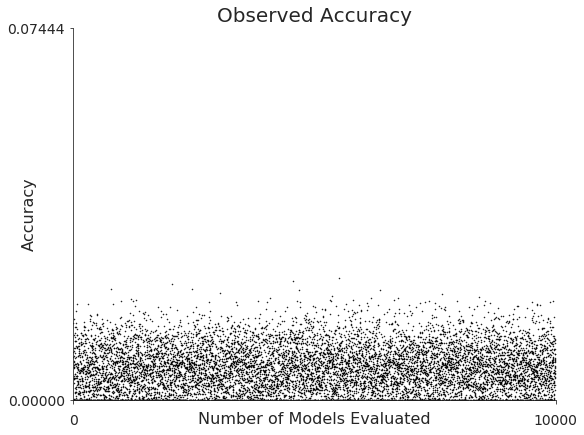

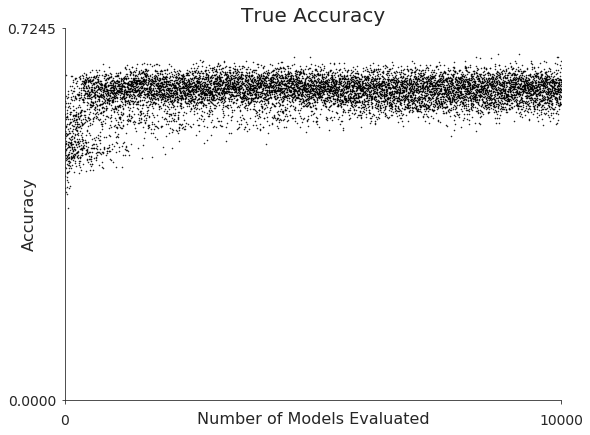

In [9]:
history, _ = plain_evolution(
    cycles=TOTAL_RESOURCES, population_size=POPULATION_SIZE,
    sample_size=SAMPLE_SIZE,
    early_observation=True)

graph_history(history)

**Plain Evolution: Maximum Step Observartion**

Next, we run plain evolution with observations after each model has been trained for the maximum number
of steps. The signal here is perfect, with the observed accuracy matching the true accuracy, but we see very few models since we are controlling for number of resources.


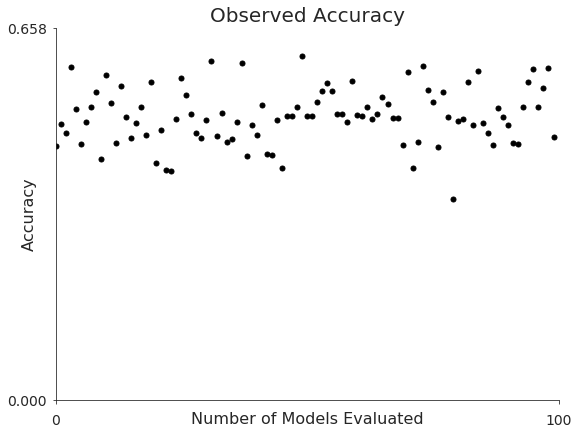

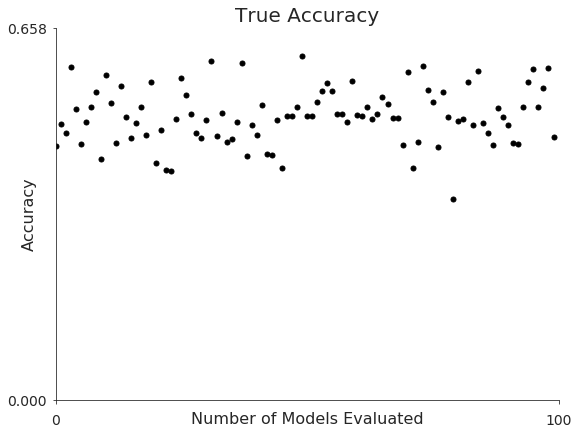

In [13]:
history, _ = plain_evolution(
    cycles=TOTAL_RESOURCES/REDUCTION_FACTOR, population_size=POPULATION_SIZE,
    sample_size=SAMPLE_SIZE, early_observation=False)

graph_history(history)

**Progressive Dynamic Hurdles**

Finally, we run Progressive Dynamic Hurdles (PDH). By establishing a hurdle, PDH is able to utilize early observations to filter out flagrantly bad models, training only the most promising models for the high-cost maximum number of train steps. This perfect signal clarifies which of these promising models are truly the best and improves the search by generating candidates from the best parents.

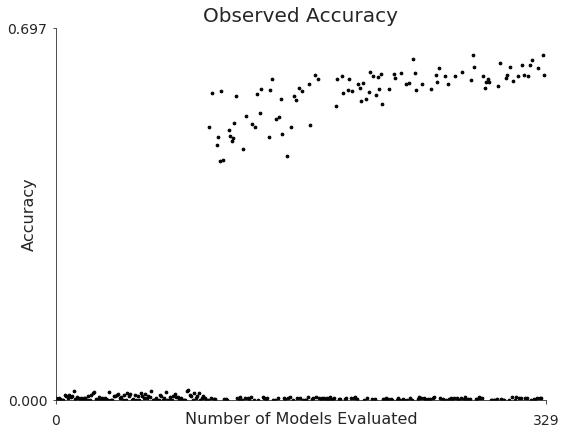

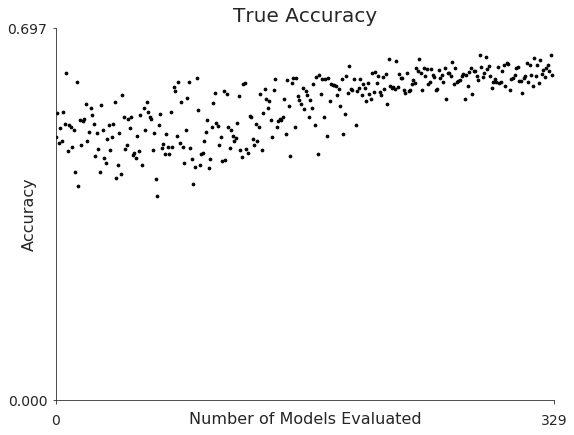

In [15]:
history, _ = pdh_evolution(train_resources=TOTAL_RESOURCES,
                           population_size=POPULATION_SIZE,
                           sample_size=SAMPLE_SIZE)

graph_history(history)

**Mean Fitness Comparison**

To demonstrate the effectiveness of Progressive Dynamic Hurdles, we compare the mean top fitness of each algorithm, with each run 500 times.

In [16]:
import numpy as np

num_trials = 500

print("===========================")
print("Mean Top Fitness Comparison")
print("===========================")

max_fitnesses = []
for _ in range(num_trials):
  _, population = plain_evolution(
      cycles=TOTAL_RESOURCES, population_size=POPULATION_SIZE,
      sample_size=SAMPLE_SIZE,
      early_observation=True)
  # Assume all models in the final population are fully evaluated
  max_fitness = max([indiv.true_accuracy for indiv in population])
  max_fitnesses.append(max_fitness)
max_fitnesses = np.array(max_fitnesses)
print("Early Observation Plain Evolution: %.4s ± %.4s" %
      (np.mean(max_fitnesses), np.std(max_fitnesses)))
  
max_fitnesses = []
for _ in range(num_trials):
  _, population = plain_evolution(
    cycles=TOTAL_RESOURCES/REDUCTION_FACTOR, population_size=POPULATION_SIZE,
    sample_size=SAMPLE_SIZE,
    early_observation=False)
  # Assume all models in the final population are fully evaluated
  max_fitness = max([indiv.true_accuracy for indiv in population])
  max_fitnesses.append(max_fitness)
max_fitnesses = np.array(max_fitnesses)
print("Max Step Observation Plain Evolution: %.4s ± %.4s" %
      (np.mean(max_fitnesses), np.std(max_fitnesses)))

max_fitnesses = []
for _ in range(num_trials):
  _, population = pdh_evolution(train_resources=TOTAL_RESOURCES,
                                population_size=POPULATION_SIZE,
                                sample_size=SAMPLE_SIZE)
  # Assume all models in the final population are fully evaluated
  max_fitness = max([indiv.true_accuracy for indiv in population])
  max_fitnesses.append(max_fitness)
max_fitnesses = np.array(max_fitnesses)
print("Progressive Dynamic Hurdles: %.4s ± %.4s" %
      (np.mean(max_fitnesses), np.std(max_fitnesses)))

Mean Top Fitness Comparison
Early Observation Plain Evolution: 0.60 ± 0.03
Max Step Observation Plain Evolution: 0.62 ± 0.02
Progressive Dynamic Hurdles: 0.64 ± 0.03
